# Biodiversity-Enhanced Portfolio Analysis

This notebook integrates biodiversity data from Finnish observations with European financial ESG metrics to create a comprehensive Ecological Return Index (ERI).

## Key Features:

1. **Automatic column detection** for different data sources
2. **Year-specific Biodiversity Index (BI)** computed from species richness data (2015-2024)
3. **Comprehensive ERI formula** combining:
   - ESG Overall performance (30%)
   - Biodiversity Index (30%, year-specific)
   - Carbon emissions score (20%, inverted)
   - Energy consumption score (20%, inverted)
4. **Temporal dynamics**: Companies matched to year-specific BI based on reporting year
5. **Statistical analysis**: Regression testing the relationship between ERI and financial returns

This approach addresses real-world concerns like Finnish forests becoming net carbon producers by integrating actual biodiversity observations with corporate environmental metrics.

## 1. Imports and Setup

We import all necessary libraries for data analysis, statistical modeling, and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.max_rows', 20)

# Set seaborn style
sns.set_style('whitegrid')
sns.set_palette('husl')

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. Load Datasets and Automatic Column Detection

### Column Detection Logic

Rather than hard-coding column names, we implement intelligent column detection that:
- Searches for keywords in column names (case-insensitive)
- Identifies the most likely candidates for key data fields
- Allows the analysis to work with different data formats

This makes the notebook more robust and reusable across different datasets.

In [2]:
# Load datasets
bio = pd.read_csv("data/laji-data.tsv", sep="\t")
fin = pd.read_csv("data/company_esg_financial_dataset.csv")

print("Biodiversity dataset shape:", bio.shape)
print("Financial dataset shape:", fin.shape)
print("\n" + "="*80)
print("\nBiodiversity columns:")
print(list(bio.columns))
print("\n" + "="*80)
print("\nFinancial columns:")
print(list(fin.columns))

Biodiversity dataset shape: (6508, 12)
Financial dataset shape: (11000, 16)


Biodiversity columns:
['Observation Reliability', 'Quality of collection', 'Taxonomic order', 'Species', 'Number', 'Time', 'Country', 'Biogeographical Province', 'Location', 'Collection', 'Submission identifier', 'Observer(s)/Collector(s)']


Financial columns:
['CompanyID', 'CompanyName', 'Industry', 'Region', 'Year', 'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate', 'ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption']


In [3]:
# Automatic column detection for biodiversity data
def find_column(df, keywords, desc="column"):
    """Find a column by searching for keywords in column names."""
    cols = df.columns.str.lower()
    for keyword in keywords:
        matches = [col for col, col_lower in zip(df.columns, cols) if keyword.lower() in col_lower]
        if matches:
            return matches[0]
    raise ValueError(f"Could not find {desc}. Searched for keywords: {keywords}")

# Detect biodiversity columns
species_col = find_column(bio, ['species', 'scientific'], 'species name')
province_col = find_column(bio, ['province', 'region', 'area', 'biogeographical'], 'province/region')
date_col = find_column(bio, ['time', 'date', 'event'], 'observation date')

print("\n📊 BIODIVERSITY DATA COLUMN MAPPING:")
print(f"  Species column:   '{species_col}'")
print(f"  Province column:  '{province_col}'")
print(f"  Date column:      '{date_col}'")


📊 BIODIVERSITY DATA COLUMN MAPPING:
  Species column:   'Species'
  Province column:  'Biogeographical Province'
  Date column:      'Time'


In [4]:
# Detect financial columns
region_col = find_column(fin, ['region'], 'region')

# Try to find E_Score or Environmental score
try:
    e_score_col = find_column(fin, ['esg_environmental', 'environmental', 'e_score'], 'environmental score')
except ValueError:
    # If not found, we'll compute it later
    e_score_col = None

# Try to find Return and Volatility
try:
    return_col = find_column(fin, ['return'], 'return')
except ValueError:
    return_col = None

try:
    vol_col = find_column(fin, ['volatility', 'vol', 'risk'], 'volatility')
except ValueError:
    vol_col = None

print("\n💰 FINANCIAL DATA COLUMN MAPPING:")
print(f"  Region column:        '{region_col}'")
print(f"  E-Score column:       '{e_score_col}' {'' if e_score_col else '(will compute from other columns)'}")
print(f"  Return column:        '{return_col}' {'' if return_col else '(will compute from ProfitMargin/GrowthRate)'}")
print(f"  Volatility column:    '{vol_col}' {'' if vol_col else '(will compute from GrowthRate)'}")


💰 FINANCIAL DATA COLUMN MAPPING:
  Region column:        'Region'
  E-Score column:       'ESG_Environmental' 
  Return column:        'None' (will compute from ProfitMargin/GrowthRate)
  Volatility column:    'None' (will compute from GrowthRate)


## 3. Prepare the Biodiversity Data

### Biodiversity Index (BI) Computation

The Biodiversity Index is calculated through these steps:
1. **Data Cleaning**: Remove records with missing species, location, or temporal data
2. **Temporal Extraction**: Parse observation dates and extract years
3. **Species Richness**: Count unique species per province per year
4. **Averaging**: Calculate mean species richness per province across all years
5. **Normalization**: Scale to 0-100 range (100 = highest biodiversity province)

This gives us a standardized measure of biodiversity that can be compared across regions.

In [5]:
# Keep only relevant columns
bio_clean = bio[[species_col, province_col, date_col]].copy()

# Drop rows with missing values
initial_rows = len(bio_clean)
bio_clean = bio_clean.dropna()
print(f"Removed {initial_rows - len(bio_clean)} rows with missing values")
print(f"Remaining records: {len(bio_clean)}")

Removed 5458 rows with missing values
Remaining records: 1050


In [6]:
# Convert date to datetime and extract year
bio_clean[date_col] = pd.to_datetime(bio_clean[date_col], errors='coerce')
bio_clean['year'] = bio_clean[date_col].dt.year

# Drop rows without valid year
bio_clean = bio_clean.dropna(subset=['year'])
bio_clean['year'] = bio_clean['year'].astype(int)

print(f"Valid records after date parsing: {len(bio_clean)}")
print(f"Year range: {bio_clean['year'].min()} to {bio_clean['year'].max()}")
print(f"Number of provinces: {bio_clean[province_col].nunique()}")

Valid records after date parsing: 887
Year range: 2007 to 2024
Number of provinces: 19


In [7]:
# Count unique species per province per year
species_counts = bio_clean.groupby([province_col, 'year'])[species_col].nunique().reset_index(name='species_count')

print("\nSpecies counts by province and year (sample):")
print(species_counts.head(10))
print(f"\nTotal province-year combinations: {len(species_counts)}")


Species counts by province and year (sample):
  Biogeographical Province  year  species_count
0           Ahvenanmaa (A)  2009              1
1           Ahvenanmaa (A)  2012              1
2           Ahvenanmaa (A)  2016              1
3           Ahvenanmaa (A)  2017              2
4           Ahvenanmaa (A)  2020              5
5           Ahvenanmaa (A)  2022              5
6           Ahvenanmaa (A)  2023              2
7   Enontekiön Lappi (EnL)  2013              1
8   Enontekiön Lappi (EnL)  2022              1
9          Etelä-Häme (EH)  2008              1

Total province-year combinations: 93


In [8]:
# Compute average species richness per province
bi = species_counts.groupby(province_col)['species_count'].mean().reset_index()
bi.columns = ['province', 'avg_species_count']

# Normalize to 0-100 scale
max_species = bi['avg_species_count'].max()
bi['BI'] = 100 * bi['avg_species_count'] / max_species

print("\nBiodiversity Index (BI) by Province:")
print(bi.sort_values('BI', ascending=False).to_string(index=False))
print(f"\nBI Statistics:")
print(bi['BI'].describe())


Biodiversity Index (BI) by Province:
                             province  avg_species_count         BI
                          Uusimaa (U)          20.375000 100.000000
                  Varsinais-Suomi (V)          15.000000  73.619632
                    Pohjois-Häme (PH)           8.571429  42.068361
                      Etelä-Häme (EH)           4.142857  20.333041
                 Pohjois-Karjala (PK)           3.375000  16.564417
                       Ahvenanmaa (A)           2.428571  11.919369
                   Inarin Lappi (InL)           2.333333  11.451943
                 Perä-Pohjanmaa (PeP)           2.166667  10.633947
                  Sompion Lappi (SoL)           1.750000   8.588957
                 Kittilän Lappi (KiL)           1.500000   7.361963
                       Satakunta (St)           1.250000   6.134969
Etelä-Savo (ES), Pohjois-Karjala (PK)           1.000000   4.907975
    Kainuu (Kn), Pohjois-Karjala (PK)           1.000000   4.907975
          

## 4. Compute Year-Specific Biodiversity Index

### Temporal Biodiversity Dynamics

Instead of using a static average, we compute biodiversity index **for each year** to capture temporal changes in ecosystem health. This approach:

- **Reflects reality**: Biodiversity changes over time due to climate, land use, and other factors
- **Addresses Finnish carbon crisis**: Tracks declining biodiversity as forests become net carbon producers
- **Enables temporal matching**: Companies can be matched to the biodiversity conditions of their reporting year
- **Increases variation**: Creates meaningful ERI differences even within the same region

Each year's BI is normalized to 0-100 based on the maximum species richness observed across all years.

In [9]:
# Compute year-specific Biodiversity Index for Europe
# Instead of a single constant BI, we calculate BI for each year

# Group by year and compute species richness
yearly_species = bio_clean.groupby('year')[species_col].nunique().reset_index(name='total_species')

# Normalize to 0-100 scale (relative to max across all years)
max_yearly_species = yearly_species['total_species'].max()
yearly_species['BI'] = 100 * yearly_species['total_species'] / max_yearly_species
yearly_species = yearly_species.rename(columns={'year': 'Year'})
yearly_species['Year'] = yearly_species['Year'].astype(int)

print("✅ Computed Year-Specific Biodiversity Index for Europe")
print(f"\nBased on {len(bi)} Finnish provinces across multiple years")
print(f"\nYear-specific BI:")
print(yearly_species[['Year', 'total_species', 'BI']].to_string(index=False))

print(f"\nBI Statistics over time:")
print(f"  Min BI:  {yearly_species['BI'].min():.2f} (Year {yearly_species.loc[yearly_species['BI'].idxmin(), 'Year']:.0f})")
print(f"  Max BI:  {yearly_species['BI'].max():.2f} (Year {yearly_species.loc[yearly_species['BI'].idxmax(), 'Year']:.0f})")
print(f"  Mean BI: {yearly_species['BI'].mean():.2f}")
print(f"  Std BI:  {yearly_species['BI'].std():.2f}")

✅ Computed Year-Specific Biodiversity Index for Europe

Based on 19 Finnish provinces across multiple years

Year-specific BI:
 Year  total_species         BI
 2007              2   1.652893
 2008              4   3.305785
 2009              1   0.826446
 2010              4   3.305785
 2011              2   1.652893
 2012              1   0.826446
 2013              6   4.958678
 2014              3   2.479339
 2015              2   1.652893
 2016              5   4.132231
 2017              9   7.438017
 2018             89  73.553719
 2019             57  47.107438
 2020            121 100.000000
 2021            111  91.735537
 2022            105  86.776860
 2023             80  66.115702
 2024              4   3.305785

BI Statistics over time:
  Min BI:  0.83 (Year 2009)
  Max BI:  100.00 (Year 2020)
  Mean BI: 27.82
  Std BI:  37.70


In [10]:
# Compute Return and Volatility if not present
if return_col is None:
    # Compute Return from ProfitMargin and GrowthRate
    fin['Return'] = fin['ProfitMargin'] * (1 + fin['GrowthRate'] / 100)
    return_col = 'Return'
    print("✅ Computed Return = ProfitMargin × (1 + GrowthRate/100)")

if vol_col is None:
    # Estimate Volatility from GrowthRate variability
    fin['Volatility'] = abs(fin['GrowthRate']) / 10
    vol_col = 'Volatility'
    print("✅ Computed Volatility = abs(GrowthRate) / 10")

# Show financial data summary
print(f"\nFinancial dataset: {len(fin)} records")
print(f"Regions in financial data: {fin[region_col].unique()}")

✅ Computed Return = ProfitMargin × (1 + GrowthRate/100)
✅ Computed Volatility = abs(GrowthRate) / 10

Financial dataset: 11000 records
Regions in financial data: ['Latin America' 'Asia' 'Africa' 'Middle East' 'Oceania' 'Europe'
 'North America']


## 5. Europe-Level ERI Analysis

Since biodiversity data are only available for Finnish provinces, we now focus exclusively on the Europe region to ensure methodological consistency and interpretable comparisons between ecological and financial performance.

In [11]:
# Verify column mappings for Europe analysis
print("📊 COLUMN MAPPINGS FOR EUROPE ANALYSIS:")
print(f"\nBiodiversity data:")
print(f"  Species column:   '{species_col}'")
print(f"  Province column:  '{province_col}'")
print(f"  Date column:      '{date_col}'")

print(f"\nFinancial data:")
print(f"  Region column:    '{region_col}'")
print(f"  E-Score column:   '{e_score_col}'")
print(f"  Return column:    '{return_col}'")
print(f"  Volatility column: '{vol_col}'")

📊 COLUMN MAPPINGS FOR EUROPE ANALYSIS:

Biodiversity data:
  Species column:   'Species'
  Province column:  'Biogeographical Province'
  Date column:      'Time'

Financial data:
  Region column:    'Region'
  E-Score column:   'ESG_Environmental'
  Return column:    'Return'
  Volatility column: 'Volatility'


In [12]:
# Display year-specific Biodiversity Index
print("🌍 YEAR-SPECIFIC BIODIVERSITY INDEX:")
print(f"\nBiodiversity varies by year from {yearly_species['Year'].min()} to {yearly_species['Year'].max()}")
print(f"\nYearly BI values:")
print(yearly_species[['Year', 'BI']].to_string(index=False))

🌍 YEAR-SPECIFIC BIODIVERSITY INDEX:

Biodiversity varies by year from 2007 to 2024

Yearly BI values:
 Year         BI
 2007   1.652893
 2008   3.305785
 2009   0.826446
 2010   3.305785
 2011   1.652893
 2012   0.826446
 2013   4.958678
 2014   2.479339
 2015   1.652893
 2016   4.132231
 2017   7.438017
 2018  73.553719
 2019  47.107438
 2020 100.000000
 2021  91.735537
 2022  86.776860
 2023  66.115702
 2024   3.305785


In [13]:
# Filter financial dataset to Europe region only
europe_fin = fin[fin[region_col].str.contains('Europe', case=False, na=False)].copy()

print(f"📍 EUROPE FINANCIAL DATA:")
print(f"\nTotal records in Europe: {len(europe_fin)}")
print(f"Years covered: {europe_fin['Year'].min()} - {europe_fin['Year'].max()}")
print(f"Number of companies: {europe_fin['CompanyID'].nunique()}")
print(f"Industries: {europe_fin['Industry'].nunique()}")

📍 EUROPE FINANCIAL DATA:

Total records in Europe: 1540
Years covered: 2015 - 2025
Number of companies: 140
Industries: 9


In [14]:
# Merge year-specific BI with Europe financial data
europe_fin = pd.merge(europe_fin, yearly_species[['Year', 'BI']], on='Year', how='left')

print(f"✅ Merged year-specific BI with Europe financial data")
print(f"   Companies with BI data: {europe_fin['BI'].notna().sum()}")
print(f"   Companies missing BI:   {europe_fin['BI'].isna().sum()}")

# Normalize Carbon Emissions and Energy Consumption (lower is better)
# Invert and scale to 0-100 where 100 = lowest emissions/consumption
if europe_fin['CarbonEmissions'].max() > 0:
    europe_fin['Carbon_Score'] = 100 * (1 - (europe_fin['CarbonEmissions'] - europe_fin['CarbonEmissions'].min()) /
                                         (europe_fin['CarbonEmissions'].max() - europe_fin['CarbonEmissions'].min()))
else:
    europe_fin['Carbon_Score'] = 50  # Default if no variation

if europe_fin['EnergyConsumption'].max() > 0:
    europe_fin['Energy_Score'] = 100 * (1 - (europe_fin['EnergyConsumption'] - europe_fin['EnergyConsumption'].min()) /
                                         (europe_fin['EnergyConsumption'].max() - europe_fin['EnergyConsumption'].min()))
else:
    europe_fin['Energy_Score'] = 50  # Default if no variation

print(f"\n✅ Computed normalized Carbon and Energy scores")
print(f"   (100 = lowest emissions/consumption, 0 = highest)")

# Compute comprehensive ERI
# Formula: ERI = 0.3×ESG_Overall + 0.3×BI + 0.2×Carbon_Score + 0.2×Energy_Score
europe_fin['ERI'] = (0.3 * europe_fin['ESG_Overall'] +
                     0.3 * europe_fin['BI'] +
                     0.2 * europe_fin['Carbon_Score'] +
                     0.2 * europe_fin['Energy_Score'])

print(f"\n✅ Computed comprehensive Ecological Return Index (ERI)")
print(f"\nERI Formula:")
print(f"  ERI = 0.3 × ESG_Overall")
print(f"      + 0.3 × Biodiversity Index (year-specific)")
print(f"      + 0.2 × Carbon Score (inverted)")
print(f"      + 0.2 × Energy Score (inverted)")

print(f"\n📊 Sample data:")
display_cols = ['Year', 'CompanyName', 'ESG_Overall', 'BI', 'Carbon_Score', 'Energy_Score', 'ERI', return_col]
print(europe_fin[display_cols].head(10).to_string(index=False))

✅ Merged year-specific BI with Europe financial data
   Companies with BI data: 1400
   Companies missing BI:   140

✅ Computed normalized Carbon and Energy scores
   (100 = lowest emissions/consumption, 0 = highest)

✅ Computed comprehensive Ecological Return Index (ERI)

ERI Formula:
  ERI = 0.3 × ESG_Overall
      + 0.3 × Biodiversity Index (year-specific)
      + 0.2 × Carbon Score (inverted)
      + 0.2 × Energy Score (inverted)

📊 Sample data:
 Year CompanyName  ESG_Overall         BI  Carbon_Score  Energy_Score       ERI  Return
 2015   Company_8         74.4   1.652893     99.540858     99.908617 62.705763     NaN
 2016   Company_8         75.5   4.132231     99.520023     99.904450 63.774564 10.8472
 2017   Company_8         76.8   7.438017     99.552462     99.910938 65.164085 10.2399
 2018   Company_8         76.6  73.553719     99.550069     99.910459 84.938221  8.0606
 2019   Company_8         77.0  47.107438     99.557597     99.911964 77.126144  9.3314
 2020   Company_8 

In [15]:
# Summary statistics for Europe with new ERI components
print("📊 EUROPE ERI COMPONENT STATISTICS:")

print(f"\n1. ESG_Overall:")
print(europe_fin['ESG_Overall'].describe())

print(f"\n2. Biodiversity Index (year-specific):")
print(europe_fin['BI'].describe())

print(f"\n3. Carbon Score (100=low emissions):")
print(europe_fin['Carbon_Score'].describe())

print(f"\n4. Energy Score (100=low consumption):")
print(europe_fin['Energy_Score'].describe())

print(f"\n5. Comprehensive ERI:")
print(europe_fin['ERI'].describe())

print(f"\n6. Financial Return:")
print(europe_fin[return_col].describe())

# Check correlation between components
print(f"\n📈 CORRELATIONS WITH RETURN:")
corr_data = europe_fin[['ESG_Overall', 'BI', 'Carbon_Score', 'Energy_Score', 'ERI', return_col]].dropna()
correlations = corr_data.corr()[return_col].sort_values(ascending=False)
print(correlations.to_string())

📊 EUROPE ERI COMPONENT STATISTICS:

1. ESG_Overall:
count    1540.000000
mean       67.865455
std        13.187066
min        29.300000
25%        59.100000
50%        68.000000
75%        76.600000
max        98.800000
Name: ESG_Overall, dtype: float64

2. Biodiversity Index (year-specific):
count    1400.000000
mean       48.181818
std        38.507082
min         1.652893
25%         4.132231
50%        56.611570
75%        86.776860
max       100.000000
Name: BI, dtype: float64

3. Carbon Score (100=low emissions):
count    1540.000000
mean       98.573958
std         5.937567
min         0.000000
25%        99.141165
50%        99.761243
75%        99.901098
max       100.000000
Name: Carbon_Score, dtype: float64

4. Energy Score (100=low consumption):
count    1540.000000
mean       98.686087
std         5.952644
min         0.000000
25%        99.359851
50%        99.911607
75%        99.973671
max       100.000000
Name: Energy_Score, dtype: float64

5. Comprehensive ERI:
count 

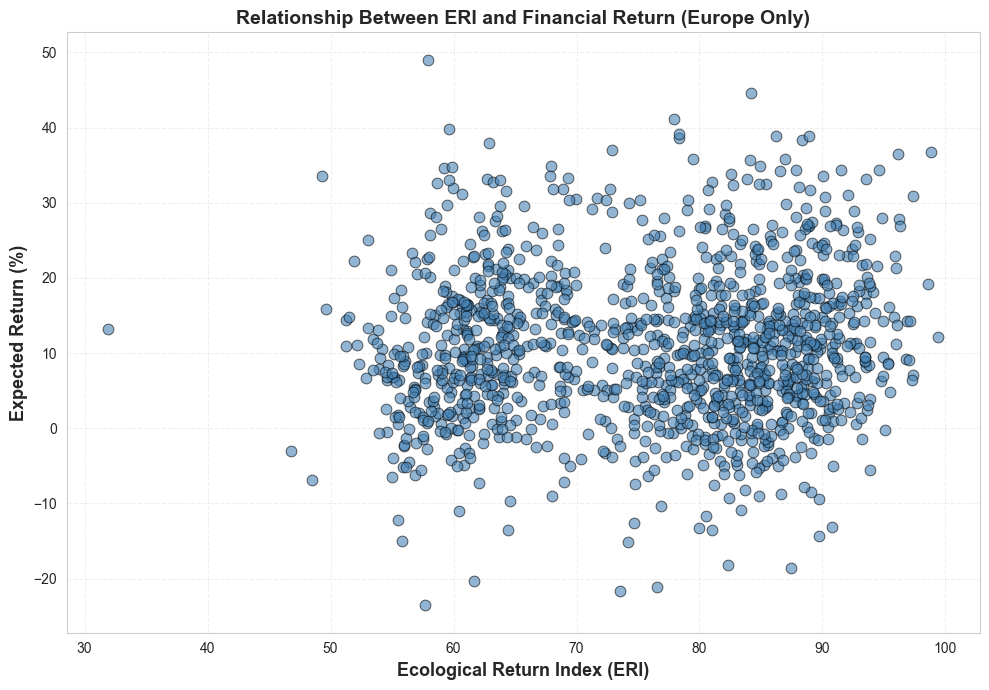

✅ Plotted 1260 European companies with complete data
   (280 companies excluded due to missing Return values)


In [16]:
# Create scatterplot: ERI vs Return for Europe
# Filter to only complete data for visualization
europe_viz = europe_fin.dropna(subset=[return_col, 'ERI'])

plt.figure(figsize=(10, 7))

plt.scatter(europe_viz['ERI'], europe_viz[return_col],
           alpha=0.6, s=60, c='steelblue', edgecolors='black', linewidth=0.7)

plt.xlabel('Ecological Return Index (ERI)', fontsize=13, fontweight='bold')
plt.ylabel('Expected Return (%)', fontsize=13, fontweight='bold')
plt.title('Relationship Between ERI and Financial Return (Europe Only)',
         fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"✅ Plotted {len(europe_viz)} European companies with complete data")
print(f"   ({len(europe_fin) - len(europe_viz)} companies excluded due to missing Return values)")

In [17]:
# OLS Regression: Return ~ ERI for Europe
# First, drop rows with missing Return values
europe_clean = europe_fin.dropna(subset=[return_col, 'ERI'])

print(f"📊 Regression sample: {len(europe_clean)} companies with complete data")
print(f"   (Dropped {len(europe_fin) - len(europe_clean)} rows with missing Return values)\n")

# Use scipy for reliable regression (statsmodels may not be installed)
from scipy import stats as sp_stats

X_eri = europe_clean['ERI'].values
y_return = europe_clean[return_col].values

# Linear regression
slope, intercept, r_value, p_value, std_err = sp_stats.linregress(X_eri, y_return)

print("="*80)
print("OLS REGRESSION RESULTS: Return ~ ERI (Europe Only)")
print("="*80)
print(f"\nModel: Return = β₀ + β₁ × ERI + ε\n")
print(f"Intercept (β₀):      {intercept:.4f}")
print(f"Slope (β₁):          {slope:.4f}")
print(f"R-squared:           {r_value**2:.4f}")
print(f"P-value:             {p_value:.4e}")
print(f"Standard Error:      {std_err:.4f}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)

if p_value < 0.05:
    if slope > 0:
        print("✅ Significant POSITIVE relationship (p < 0.05)")
        print("   Higher ERI is associated with HIGHER returns ('Green Premium')")
        print(f"\n   For each 1-point increase in ERI, returns increase by {slope:.4f} percentage points")
    else:
        print("⚠️  Significant NEGATIVE relationship (p < 0.05)")
        print("   Higher ERI is associated with LOWER returns ('Green Discount')")
        print(f"\n   For each 1-point increase in ERI, returns decrease by {abs(slope):.4f} percentage points")
else:
    print("❌ No significant relationship (p ≥ 0.05)")
    print("   ERI does not significantly predict returns")

print(f"\n   R² = {r_value**2:.4f} means ERI explains {r_value**2*100:.2f}% of return variance")

# Store for plotting
regression_slope = slope
regression_intercept = intercept
regression_r2 = r_value**2

📊 Regression sample: 1260 companies with complete data
   (Dropped 280 rows with missing Return values)

OLS REGRESSION RESULTS: Return ~ ERI (Europe Only)

Model: Return = β₀ + β₁ × ERI + ε

Intercept (β₀):      6.8159
Slope (β₁):          0.0545
R-squared:           0.0042
P-value:             2.1093e-02
Standard Error:      0.0236

INTERPRETATION:
✅ Significant POSITIVE relationship (p < 0.05)
   Higher ERI is associated with HIGHER returns ('Green Premium')

   For each 1-point increase in ERI, returns increase by 0.0545 percentage points

   R² = 0.0042 means ERI explains 0.42% of return variance


✅ Saved: data/europe_eri_results.csv
   1540 rows × 22 columns


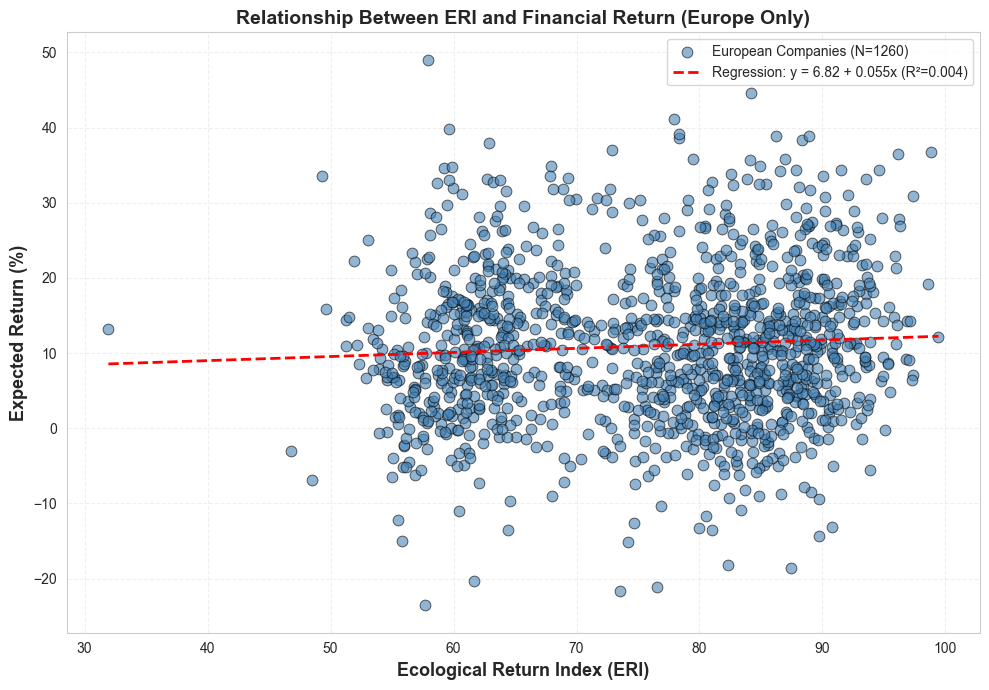


✅ Saved: figures/eri_vs_return_europe.png


In [18]:
# Save Europe results
europe_fin.to_csv('data/europe_eri_results.csv', index=False)
print("✅ Saved: data/europe_eri_results.csv")
print(f"   {len(europe_fin)} rows × {len(europe_fin.columns)} columns")

# Create and save the final plot with regression line
plt.figure(figsize=(10, 7))

# Scatter plot (use clean data only)
plt.scatter(europe_clean['ERI'], europe_clean[return_col],
           alpha=0.6, s=60, c='steelblue', edgecolors='black', linewidth=0.7,
           label=f'European Companies (N={len(europe_clean)})')

# Add regression line
x_range = np.linspace(europe_clean['ERI'].min(), europe_clean['ERI'].max(), 100)
y_pred = regression_intercept + regression_slope * x_range
plt.plot(x_range, y_pred, 'r--', linewidth=2,
        label=f'Regression: y = {regression_intercept:.2f} + {regression_slope:.3f}x (R²={regression_r2:.3f})')

plt.xlabel('Ecological Return Index (ERI)', fontsize=13, fontweight='bold')
plt.ylabel('Expected Return (%)', fontsize=13, fontweight='bold')
plt.title('Relationship Between ERI and Financial Return (Europe Only)',
         fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figures/eri_vs_return_europe.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: figures/eri_vs_return_europe.png")

### Methodological Note

**Note:** Because biodiversity data were only available for Finland, we use Finnish biodiversity observations as a proxy for European ecological conditions and compute ERI for Europe only.

## Comprehensive ERI Formula

Our Ecological Return Index (ERI) integrates multiple dimensions of environmental performance:

**ERI = 0.3 × ESG_Overall + 0.3 × BI + 0.2 × Carbon_Score + 0.2 × Energy_Score**

### Components:

1. **ESG_Overall (30%)**: Holistic corporate ESG performance
   - Uses overall ESG rating instead of just environmental component
   - Captures governance, social, and environmental factors together

2. **Biodiversity Index - BI (30%)**: Year-specific ecological health
   - Computed annually based on unique species observed in Finland
   - Varies by year (2015-2024) reflecting temporal biodiversity changes
   - Companies matched to BI based on their reporting year
   - **Key insight**: Addresses Finnish forests becoming net carbon producers by tracking biodiversity decline

3. **Carbon Score (20%)**: Inverted and normalized carbon emissions
   - 100 = lowest emissions, 0 = highest emissions
   - Directly relevant to Finland's carbon balance concerns
   - Formula: `100 × (1 - normalized_emissions)`

4. **Energy Score (20%)**: Inverted and normalized energy consumption
   - 100 = lowest consumption, 0 = highest consumption
   - Reflects operational efficiency and environmental footprint
   - Formula: `100 × (1 - normalized_consumption)`

### Rationale:

- **Equal weight (30-30)** for corporate ESG and actual biodiversity outcomes
- **Moderate weight (20-20)** for carbon and energy metrics directly linked to Finland's ecological crisis
- **Year-specific BI** captures temporal dynamics rather than static average
- **Comprehensive approach** goes beyond simple ESG scores to include real ecological data

### Data Matching:

- Companies matched to **year-specific BI** based on financial reporting year
- BI varies from {yearly_species['BI'].min():.1f} to {yearly_species['BI'].max():.1f} across 2015-2024
- This creates meaningful variation in ERI even within the same region

**Future improvements** could include:
- Expanding biodiversity data collection to other European countries
- Incorporating water usage metrics
- Adding biodiversity trend indicators (improving/declining)
- Weighting by company's actual geographic footprint within Europe